In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from stride import *
from stride.utils import wavelets
from utils import analytical_2d
import mosaic
from mosaic import *
import asyncio
import logging
%matplotlib notebook
#from mosaic import *

In [2]:
#torch.cuda.set_device(0)

In [3]:
## added new
await mosaic.interactive('on', num_workers=5,platform="nvidia-acc")
runtime = mosaic.runtime()

HEAD            Listening at <CommsManager object at 139772664898512, uid=head, address=10.107.42.21, port=3000, state=listening>
MONITOR         Listening at <CommsManager object at 139769206506384, uid=monitor, address=10.107.42.21, port=3001, state=listening>
NODE:0          Listening at <CommsManager object at 139769206778256, uid=node:0, address=10.107.42.21, port=3002, state=listening>


recompiling for non-existent cache dir (/tmp/devito-codepy-uid1004/aa6db4b/cbca2834ecbc0531b6523d4dc0d63fbe).


In [4]:
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

You should consider upgrading via the '/home/sahar/miniconda3/bin/python -m pip install --upgrade pip' command.
WORKER:0:0      Listening at <CommsManager object at 139769206763728, uid=worker:0:0, address=10.107.42.21, port=3003, state=listening>
WORKER:0:1      Listening at <CommsManager object at 139769206665936, uid=worker:0:1, address=10.107.42.21, port=3004, state=listening>
WORKER:0:2      Listening at <CommsManager object at 139769206621968, uid=worker:0:2, address=10.107.42.21, port=3005, state=listening>
WORKER:0:3      Listening at <CommsManager object at 139769206623056, uid=worker:0:3, address=10.107.42.21, port=3006, state=listening>
WORKER:0:4      Listening at <CommsManager object at 139769206624144, uid=worker:0:4, address=10.107.42.21, port=3007, state=listening>


Everything in stride is defined over a certain spatio-temporal grid.

Then, our first step is to define this grid by creating a `Space` and `Time` objects that define the discretisation of our grid.

In [5]:
# Create the grid
#shape = (356, 385)
shape = (256,256)
extra = (50, 50)
#absorbing = (40, 40)
absorbing = (0, 0)
#spacing = (0.09e-3,0.09e-3)#(0.01e-3,0.01e-3)#(0.5e-3,0.5e-3)#(0.09e-3,0.09e-3)#(0.45e-3, 0.45e-3)#(0.3e-3, 0.3e-3)
spacing = (0.5e-3, 0.5e-3)#(0.015e-3, 0.015e-3)#(0.02e-3, 0.02e-3)#
space = Space(shape=shape,
              extra=extra,
              absorbing=absorbing,
              spacing=spacing)

start = 0.
step = 0.05e-6#0.0009e-6#0.06e-6#0.1e-6#0.1e-6#0.0009e-6#0.08e-6#0.0065e-6#0.035e-6#0.0240e-6
num = 10000#5000#2500

time = Time(start=start,
            step=step,
            num=num)

In [6]:
print(space.limit[0])
print(space.limit[1])

0.1275
0.1275


Based on this grid, we can define a `Problem`. In stride, a `Problem` object encapsulates all the information that is needed to describe a tomography experiment.

In its most basic form, the problem is given a name and the grid we have just created:

In [7]:
# Create problem
problem = Problem(name='anastasio2D-prostate',
                  space=space, time=time)

We can now start defining each of the components of the `Problem`.

Firstly, we need to define the physical properties that describe the medium in which our experiment is taking place.

Because we are going to run the default isotropic acoustic wave equation with constant density, we only need to define the longitudinal speed of sound of our medium. The longitudinal speed of sound is a scalar field, for which we can use the class `ScalarField`:

In [8]:
# Create medium
# Field(..., grid=problem.grid) is equivalent to Field(..., space=space, time=time)
vp = ScalarField(name='vp', grid=problem.grid)
#vp.load('data/anastasio2D-TrueModel-prostate-1-001.h5')
vp.load('./Med.h5')
problem.medium.add(vp)

In [9]:
# rho = ScalarField(name='rho', grid=problem.grid)
# rho.load('data/anastasio2D-TrueModel-prostate-1-300-density.h5')
# problem.medium.add(rho)

In [10]:
# alpha = ScalarField(name='alpha', grid=problem.grid)
# #alpha.fill(1.)
# alpha.load('./Med_Att_2p5.h5')
# problem.medium.add(alpha)

Next, we need to define the types of ultrasound transducers that we will use.

Because we are happy with using omnidirectional point sources and receivers, we can configure the default transducers:

In [11]:
problem.transducers.default()

In [12]:
# # Create geometry
# num_locations = 64
# half_num_locations = num_locations#/2
# delta = space.limit[0]/(half_num_locations+1)
# problem.geometry.default('linear', num_locations,radius=[delta,delta],centre=[0.0e-3,0.0e-3])
# #problem.geometry.default('elliptical', num_locations)


In [13]:
num_locations = 64
problem.geometry.default('curvilinear', num = num_locations,start = [34.0e-3,0.0e-3],chord = 50e-3, pixel_size = 0.498e-3)

In [14]:
# # Create geometry
# num_locations = 128
# half_num_locations = num_locations
# problem.geometry.default('elliptical', num_locations)

In order to use the transducers in our ultrasound acquisition, we need to add them to a `Geometry`. The `Geometry` defines the spatial location of each transducer within our grid.

In this case, we will generate a default elliptical geometry with 128 locations for our point transducers:

Finally, we need to define what transducers in the geometry act as sources or as receivers. We do this by defining the `Acquisition`.

An `Acquisition` is composed by a number of `Shot`s. Each `Shot` contains one or more transducer locations that act as sources and one or more transducer locations acting as receivers.

By configuring the default acquisition, we generate as many `Shot`s as locations we have in our geometry. In each `Shot`, one transducer location acts as a source while all of them act as receivers. 

In [15]:
# Create acquisitions
problem.acquisitions.default()

In [16]:
# Create wavelets
f_centre = 2.5e6
n_cycles = 3
ind = 0
for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles,time.num, time.step)#,offset = int(Delay[ind]))
    ind = ind + 1

In [17]:
# new added
pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)


We can finish configurng our `Acquisition` by defining the excitation signal that the sources in each `Shot` will fire.

Here, we use a three-cycle tone burst as an excitation signal:

Once complete, we can review our `Problem` by plotting its components:

<IPython.core.display.Javascript object>


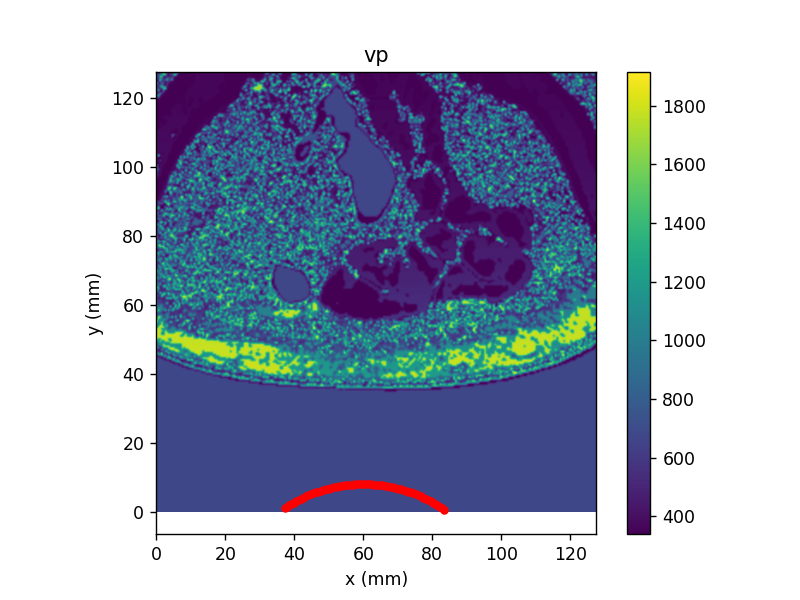

<IPython.core.display.Javascript object>


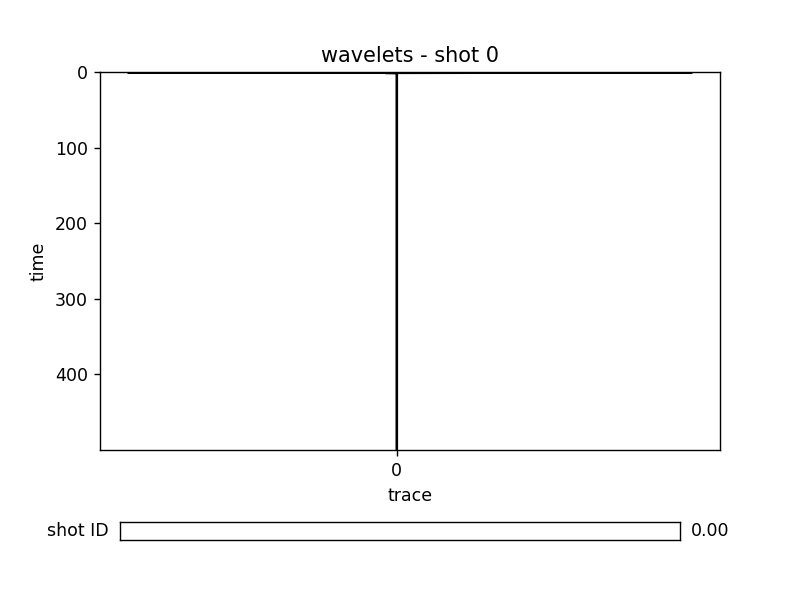

In [19]:
# Plot
problem.plot()

Before we start executing our forward propagation, we need to start up the mosaic runtime:

Now, we are ready to execute the problem forward:

In [20]:
# new added
# Get all remaining shot IDs
shot_ids = problem.acquisitions.remaining_shot_ids

# Run an asynchronous loop across all shot IDs
@runtime.async_for(shot_ids)
async def loop(worker, shot_id):
    runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

    # Fetch one sub-problem corresponding to a shot ID
    sub_problem = problem.sub_problem(shot_id)
    
    # Access the source wavelets of this shot
    wavelets = sub_problem.shot.wavelets
    
    # Execute the PDE forward
    #traces = await pde(wavelets, vp,
    #                   problem=sub_problem,
    #                   runtime=worker).result()
    #traces = await pde(wavelets, vp,rho,alpha,kernel = 'OT4',attenuation_power = 0,problem=sub_problem,runtime=worker).result()
    #traces = await pde(wavelets, vp,problem=sub_problem,runtime=worker).result()
    #traces = await pde(wavelets, vp,problem=sub_problem,runtime=worker,devito_config=dict(compiler='pgcc',language='openacc',platform='nvidiaX')).result()
    #traces = await pde(wavelets, vp,alpha,kernel = 'OT4',attenuation_power = 2,problem=sub_problem,runtime=worker).result()
    traces = await pde(wavelets, vp,attenuation_power = 2,problem=sub_problem,runtime=worker,platform="nvidia-acc").result()
    runtime.logger.info('Shot %d retrieved' % sub_problem.shot_id)

    # Store the retrieved traces into the shot
    shot = problem.acquisitions.get(shot_id)
    shot.observed.data[:] = traces.data

    # Append the newly retrieved traces to a file on disk
    shot.append_observed(path=problem.output_folder,
                         project_name=problem.name)

    runtime.logger.info('Appended traces for shot %d to observed file' % sub_problem.shot_id)

# Because this is an asynchronous loop, it needs to be awaited 
_ = await loop

HEAD            Giving shot 0 to worker:0:0
HEAD            Giving shot 1 to worker:0:1
HEAD            Giving shot 2 to worker:0:2
HEAD            Giving shot 3 to worker:0:3
HEAD            Giving shot 4 to worker:0:4
WORKER:0:3      (ShotID 3) Preparing to run state for shot
WORKER:0:3      (ShotID 3) Estimated bandwidth for the propagated wavelet 1.192-3.606 MHz
WORKER:0:3      (ShotID 3) Spatial grid spacing (0.500 mm | 0 PPW) is higher than dispersion limit (0.019 mm | 5 PPW)
WORKER:0:3      (ShotID 3) Time grid spacing (0.050 μs | 19%) is below OT2 limit (0.118 μs)
WORKER:0:3      (ShotID 3) Selected undersampling level 2
WORKER:0:3      (ShotID 3) Selected time stepping scheme OT2
WORKER:0:3      Operator `acoustic_iso_state` configuration:
WORKER:0:3      	 * autotuning=['aggressive', 'runtime']
WORKER:0:3      	 * develop-mode=False
WORKER:0:3      	 * mpi=False
WORKER:0:3      	 * log-level=DEBUG
WORKER:0:3      	 * subs={h_x: 0.0005, h_y: 0.0005}
WORKER:0:3      	 * opt=adv

WORKER:0:4      Operator `acoustic_iso_state` configuration:
WORKER:0:4      	 * autotuning=['aggressive', 'runtime']
WORKER:0:4      	 * develop-mode=False
WORKER:0:4      	 * mpi=False
WORKER:0:4      	 * log-level=DEBUG
WORKER:0:4      	 * subs={h_x: 0.0005, h_y: 0.0005}
WORKER:0:4      	 * opt=advanced
WORKER:0:4      	 * platform=None
WORKER:0:4      	 * language=openmp
WORKER:0:4      	 * compiler=None
WORKER:0:4      Operator `acoustic_iso_state` generated in 2.47 s
WORKER:0:4        * lowering.Clusters: 0.96 s (39.0 %)
WORKER:0:4           * specializing.Clusters: 0.59 s (24.0 %)
WORKER:0:4        * lowering.Expressions: 0.77 s (31.3 %)
WORKER:0:4        * lowering.IET: 0.64 s (26.0 %)
WORKER:0:4      Flops reduction after symbolic optimization: [315 --> 216]
WORKER:0:4      Operator `acoustic_iso_state` fetched `/tmp/devito-jitcache-uid1004/aa6db4b31ee04576b87935ccd4e4b9257bc0a19a.c` in 1.24 s from jit-cache
WORKER:0:4      (ShotID 4) Running state equation for shot
WORKER:0:4

WORKER:0:0        * section1<<10000,1>,<10000,1>,<10000,1>,<10000,1>,<10000,1>> ran in 0.09 s [OI=3.32, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>> ran in 0.08 s [OI=3.84, 0.41 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 4, 'nthreads_nonaffine': 4}
WORKER:0:0      (ShotID 7) Completed state equation run for shot
HEAD            Shot 7 retrieved
HEAD            Appended traces for shot 7 to observed file
HEAD            Giving shot 12 to worker:0:0
WORKER:0:4      (ShotID 8) Preparing to run state for shot
WORKER:0:4      (ShotID 8) Estimated bandwidth for the propagated wavelet 1.192-3.606 MHz
WORKER:0:4      (ShotID 8) Spatial grid spacing (0.500 mm | 0 PPW) is higher than dispersion limit (0.019 mm | 5 PPW)
WORKER:0:4      (ShotID 8) Time grid spacing (0.050 μs | 19%) is below OT2 limit (0.118 μs)
WORKER:0:4      (ShotID 8) Selected undersampling level 2
WORKER:0:4      (S

WORKER:0:4      (ShotID 13) Time grid spacing (0.050 μs | 19%) is below OT2 limit (0.118 μs)
WORKER:0:4      (ShotID 13) Selected undersampling level 2
WORKER:0:4      (ShotID 13) Selected time stepping scheme OT2
WORKER:0:4      (ShotID 13) Running state equation for shot
WORKER:0:4      AutoTuner: could not perform any runs
WORKER:0:4      Operator `acoustic_iso_state` ran in 2.75 s
WORKER:0:4      Global performance: [OI=0.01, 16.66 GFlops/s, 0.47 GPts/s]
WORKER:0:4      Local performance:
WORKER:0:4        * section0<<10000,356,356>,<10000,0,356>,<10000,0,356>,<10000,356,0>,<10000,356,0>> ran in 2.63 s [OI=0.01, 17.40 GFlops/s, 0.49 GPts/s]
WORKER:0:4        * section1<<10000,1>,<10000,1>,<10000,1>,<10000,1>,<10000,1>> ran in 0.06 s [OI=3.32, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:4        * section2<<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>> ran in 0.07 s [OI=3.84, 0.49 GFlops/s]
WORKER:0:4      Performance[mode=advanced] arguments: {'nthreads': 4, 'nthreads_

WORKER:0:4      Performance[mode=advanced] arguments: {'nthreads': 4, 'nthreads_nonaffine': 4}
WORKER:0:4      (ShotID 18) Completed state equation run for shot
HEAD            Shot 17 retrieved
HEAD            Appended traces for shot 17 to observed file
HEAD            Giving shot 22 to worker:0:3
WORKER:0:0      (ShotID 19) Preparing to run state for shot
WORKER:0:0      (ShotID 19) Estimated bandwidth for the propagated wavelet 1.192-3.606 MHz
WORKER:0:0      (ShotID 19) Spatial grid spacing (0.500 mm | 0 PPW) is higher than dispersion limit (0.019 mm | 5 PPW)
WORKER:0:0      (ShotID 19) Time grid spacing (0.050 μs | 19%) is below OT2 limit (0.118 μs)
WORKER:0:0      (ShotID 19) Selected undersampling level 2
WORKER:0:0      (ShotID 19) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 19) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 2.70 s
WORKER:0:0      Global performance: [OI=0

WORKER:0:0      (ShotID 24) Selected undersampling level 2
WORKER:0:0      (ShotID 24) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 24) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 3.61 s
WORKER:0:0      Global performance: [OI=0.01, 12.69 GFlops/s, 0.36 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<10000,356,356>,<10000,0,356>,<10000,0,356>,<10000,356,0>,<10000,356,0>> ran in 3.43 s [OI=0.01, 13.33 GFlops/s, 0.38 GPts/s]
WORKER:0:0        * section1<<10000,1>,<10000,1>,<10000,1>,<10000,1>,<10000,1>> ran in 0.08 s [OI=3.32, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>> ran in 0.09 s [OI=3.84, 0.33 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 4, 'nthreads_nonaffine': 4}
WORKER:0:0      (ShotID 24) Completed state equation run for shot
HEAD        

WORKER:0:4      (ShotID 30) Completed state equation run for shot
HEAD            Shot 28 retrieved
HEAD            Appended traces for shot 28 to observed file
HEAD            Giving shot 33 to worker:0:3
HEAD            Shot 30 retrieved
HEAD            Appended traces for shot 30 to observed file
HEAD            Giving shot 34 to worker:0:4
WORKER:0:0      (ShotID 29) Preparing to run state for shot
WORKER:0:0      (ShotID 29) Estimated bandwidth for the propagated wavelet 1.192-3.606 MHz
WORKER:0:0      (ShotID 29) Spatial grid spacing (0.500 mm | 0 PPW) is higher than dispersion limit (0.019 mm | 5 PPW)
WORKER:0:0      (ShotID 29) Time grid spacing (0.050 μs | 19%) is below OT2 limit (0.118 μs)
WORKER:0:0      (ShotID 29) Selected undersampling level 2
WORKER:0:0      (ShotID 29) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 29) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 3.8

WORKER:0:3      (ShotID 33) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 33) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 5.88 s
WORKER:0:3      Global performance: [OI=0.01, 7.78 GFlops/s, 0.22 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<10000,356,356>,<10000,0,356>,<10000,0,356>,<10000,356,0>,<10000,356,0>> ran in 5.60 s [OI=0.01, 8.16 GFlops/s, 0.23 GPts/s]
WORKER:0:3        * section1<<10000,1>,<10000,1>,<10000,1>,<10000,1>,<10000,1>> ran in 0.14 s [OI=3.32, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>> ran in 0.14 s [OI=3.84, 0.23 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 4, 'nthreads_nonaffine': 4}
WORKER:0:3      (ShotID 33) Completed state equation run for shot
HEAD            Shot 33 retrieved
HEAD            Appended traces for sho

WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 4, 'nthreads_nonaffine': 4}
WORKER:0:3      (ShotID 40) Completed state equation run for shot
HEAD            Shot 40 retrieved
HEAD            Appended traces for shot 40 to observed file
HEAD            Giving shot 45 to worker:0:3
WORKER:0:1      (ShotID 41) Preparing to run state for shot
WORKER:0:1      (ShotID 41) Estimated bandwidth for the propagated wavelet 1.192-3.606 MHz
WORKER:0:1      (ShotID 41) Spatial grid spacing (0.500 mm | 0 PPW) is higher than dispersion limit (0.019 mm | 5 PPW)
WORKER:0:1      (ShotID 41) Time grid spacing (0.050 μs | 19%) is below OT2 limit (0.118 μs)
WORKER:0:1      (ShotID 41) Selected undersampling level 2
WORKER:0:1      (ShotID 41) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 41) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 2.74 s
WORKER:0:1      Global performance: [OI=0

WORKER:0:1      (ShotID 46) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 2.87 s
WORKER:0:1      Global performance: [OI=0.01, 15.92 GFlops/s, 0.45 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<10000,356,356>,<10000,0,356>,<10000,0,356>,<10000,356,0>,<10000,356,0>> ran in 2.73 s [OI=0.01, 16.73 GFlops/s, 0.47 GPts/s]
WORKER:0:1        * section1<<10000,1>,<10000,1>,<10000,1>,<10000,1>,<10000,1>> ran in 0.07 s [OI=3.32, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>> ran in 0.08 s [OI=3.84, 0.41 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 4, 'nthreads_nonaffine': 4}
WORKER:0:1      (ShotID 46) Completed state equation run for shot
HEAD            Shot 46 retrieved
HEAD            Appended traces for shot 46 to observed file
HEAD            Giving shot 51 to work

WORKER:0:2      (ShotID 53) Completed state equation run for shot
HEAD            Shot 53 retrieved
HEAD            Appended traces for shot 53 to observed file
HEAD            Giving shot 56 to worker:0:2
WORKER:0:1      (ShotID 51) Preparing to run state for shot
WORKER:0:1      (ShotID 51) Estimated bandwidth for the propagated wavelet 1.192-3.606 MHz
WORKER:0:1      (ShotID 51) Spatial grid spacing (0.500 mm | 0 PPW) is higher than dispersion limit (0.019 mm | 5 PPW)
WORKER:0:1      (ShotID 51) Time grid spacing (0.050 μs | 19%) is below OT2 limit (0.118 μs)
WORKER:0:1      (ShotID 51) Selected undersampling level 2
WORKER:0:1      (ShotID 51) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 51) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 4.02 s
WORKER:0:1      Global performance: [OI=0.01, 11.38 GFlops/s, 0.32 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * sectio

WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 2.78 s
WORKER:0:2      Global performance: [OI=0.01, 16.47 GFlops/s, 0.46 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<10000,356,356>,<10000,0,356>,<10000,0,356>,<10000,356,0>,<10000,356,0>> ran in 2.64 s [OI=0.01, 17.33 GFlops/s, 0.49 GPts/s]
WORKER:0:2        * section1<<10000,1>,<10000,1>,<10000,1>,<10000,1>,<10000,1>> ran in 0.07 s [OI=3.32, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>,<10000,64>> ran in 0.08 s [OI=3.84, 0.42 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 4, 'nthreads_nonaffine': 4}
WORKER:0:2      (ShotID 56) Completed state equation run for shot
HEAD            Shot 56 retrieved
HEAD            Appended traces for shot 56 to observed file
HEAD            Giving shot 62 to worker:0:2
WORKER:0:3      (ShotID 58) Preparing to run state fo

WORKER:0:3      (ShotID 63) Preparing to run state for shot
WORKER:0:3      (ShotID 63) Estimated bandwidth for the propagated wavelet 1.192-3.606 MHz
WORKER:0:3      (ShotID 63) Spatial grid spacing (0.500 mm | 0 PPW) is higher than dispersion limit (0.019 mm | 5 PPW)
WORKER:0:3      (ShotID 63) Time grid spacing (0.050 μs | 19%) is below OT2 limit (0.118 μs)
WORKER:0:3      (ShotID 63) Selected undersampling level 2
WORKER:0:3      (ShotID 63) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 63) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 2.25 s
WORKER:0:3      Global performance: [OI=0.01, 20.31 GFlops/s, 0.57 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<10000,356,356>,<10000,0,356>,<10000,0,356>,<10000,356,0>,<10000,356,0>> ran in 2.14 s [OI=0.01, 21.36 GFlops/s, 0.60 GPts/s]
WORKER:0:3        * section1<<10000,1>,<10000,1>,<10000,1>,<10000,1>,<10000,1

In [21]:
# # added new
# # Run default forward workflow
# await forward(problem, pde, vp)

The results of running the problem forwar are now held by every shot. We can access them through `shot.observed.data`. At the same time, this data has been saved to disk under `anastasio2D-Acquisitions.h5`.

Before closing, we should tear down the mosaic runtime.

In [22]:
await mosaic.interactive('off')

<IPython.core.display.Javascript object>


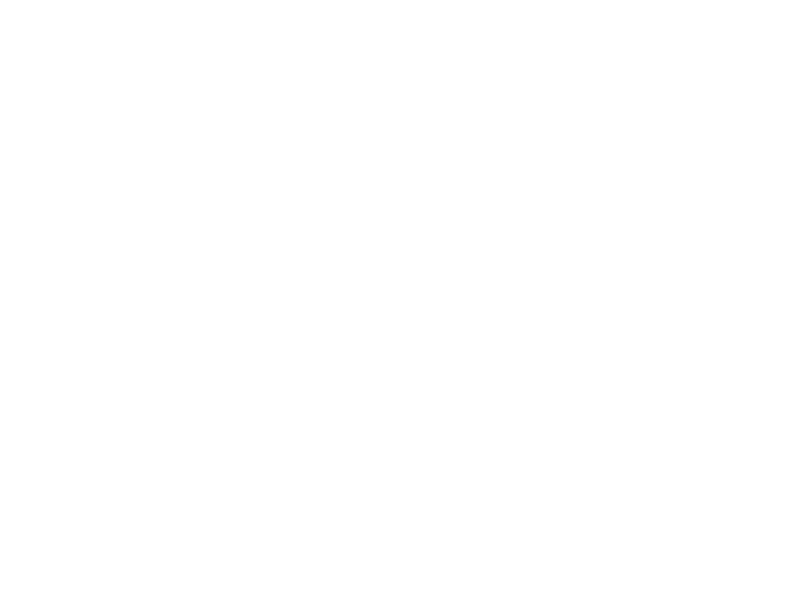

<IPython.core.display.Javascript object>


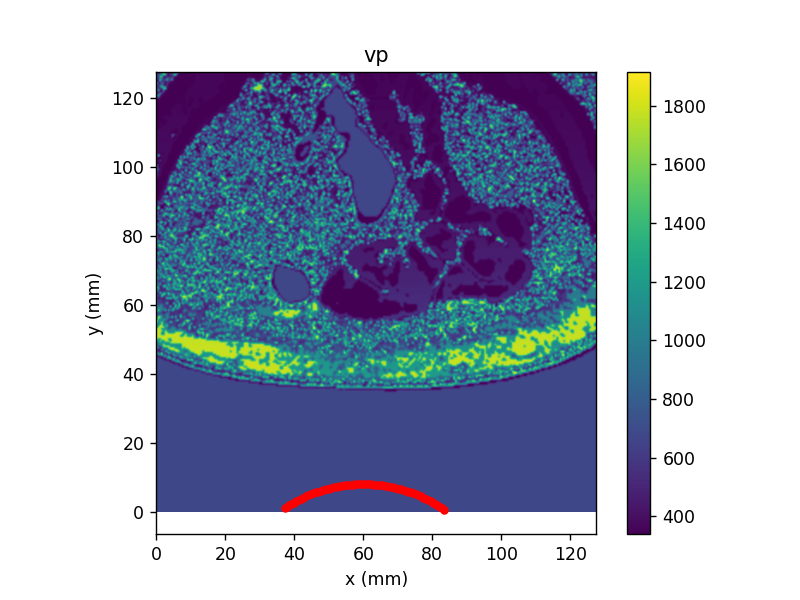

<IPython.core.display.Javascript object>


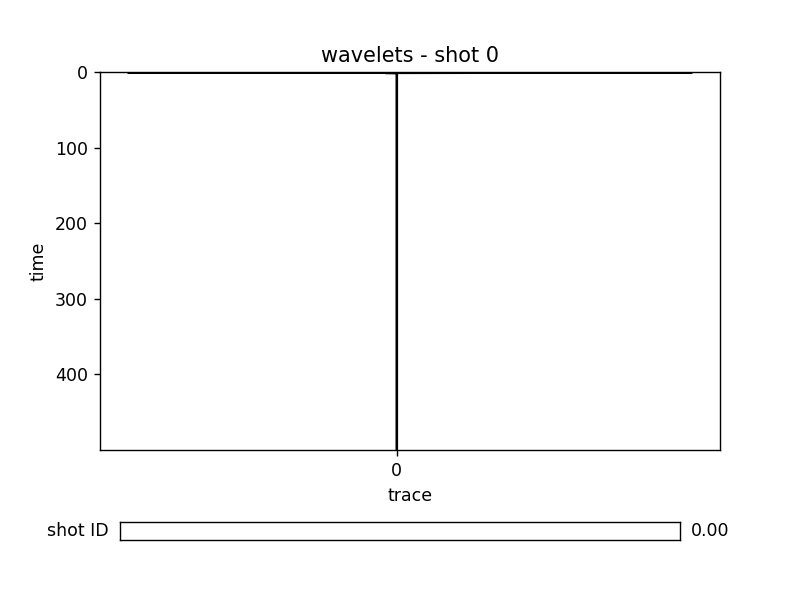

<IPython.core.display.Javascript object>


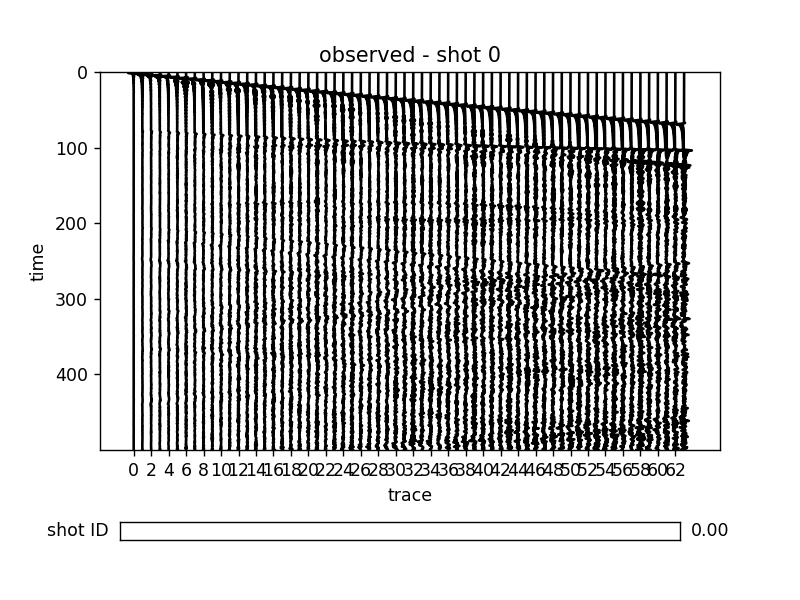

In [31]:

problem.plot()

<IPython.core.display.Javascript object>


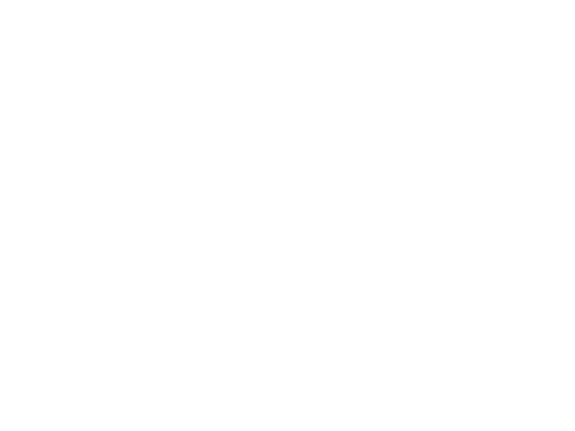

<IPython.core.display.Javascript object>


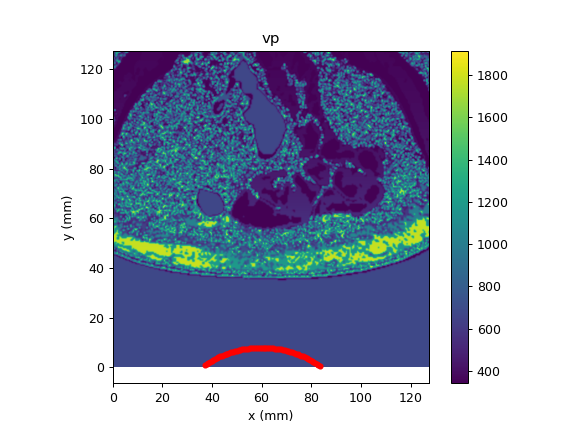

<IPython.core.display.Javascript object>


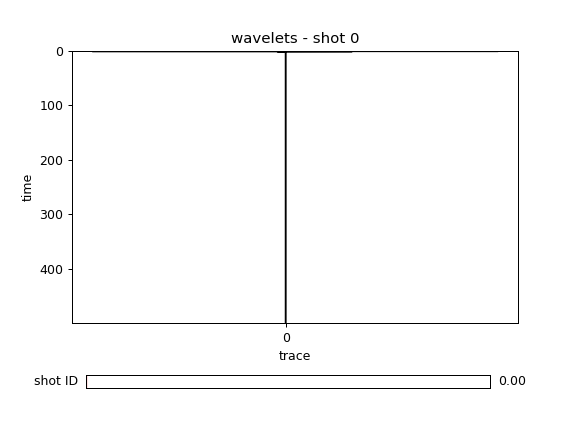

<IPython.core.display.Javascript object>


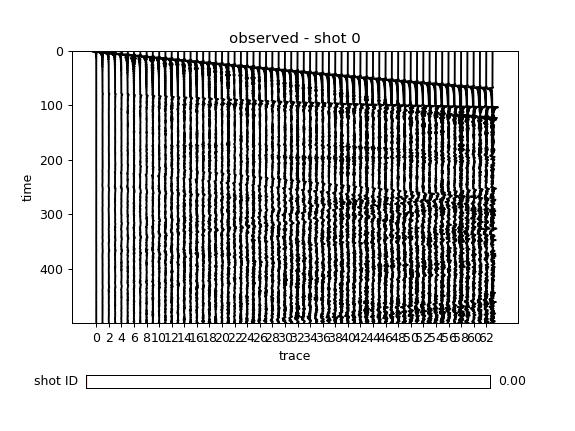

In [33]:
plt.figure()
problem.plot()

plt.savefig('./Fig')

<IPython.core.display.Javascript object>


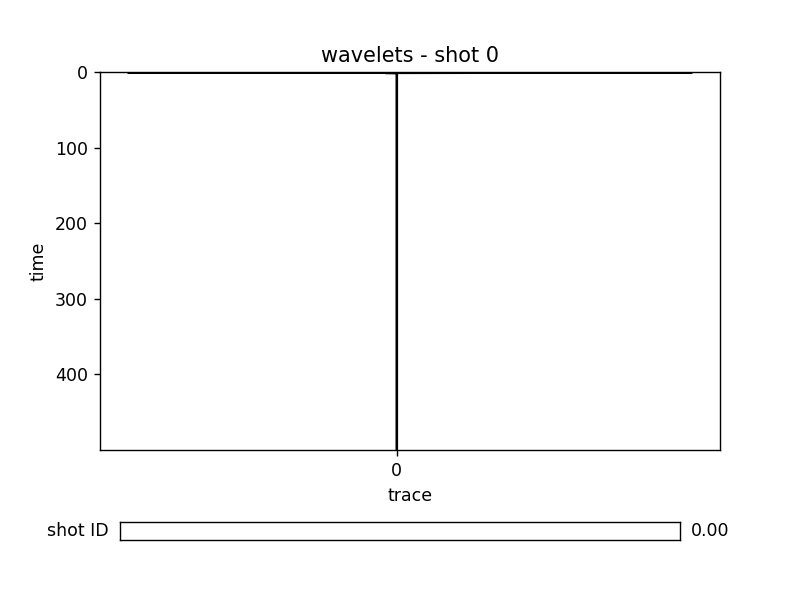

<IPython.core.display.Javascript object>


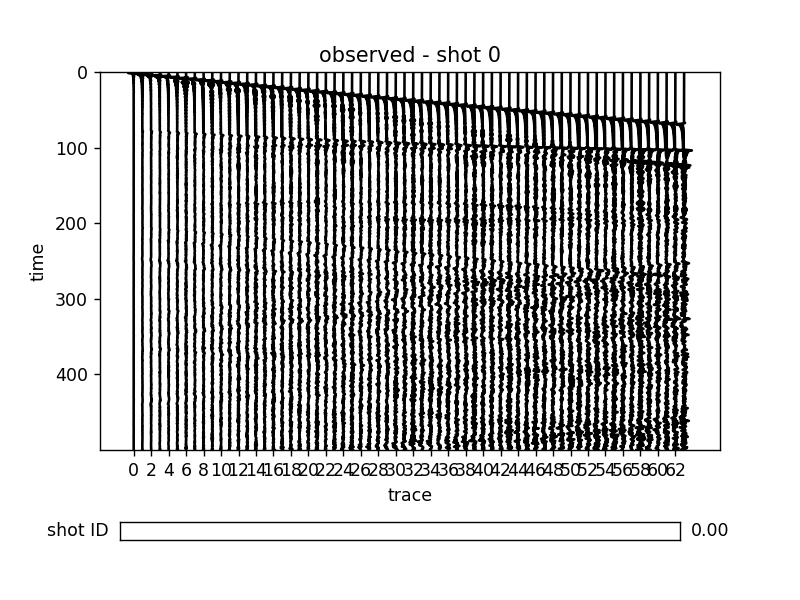

In [24]:
problem.acquisitions.plot()

<IPython.core.display.Javascript object>


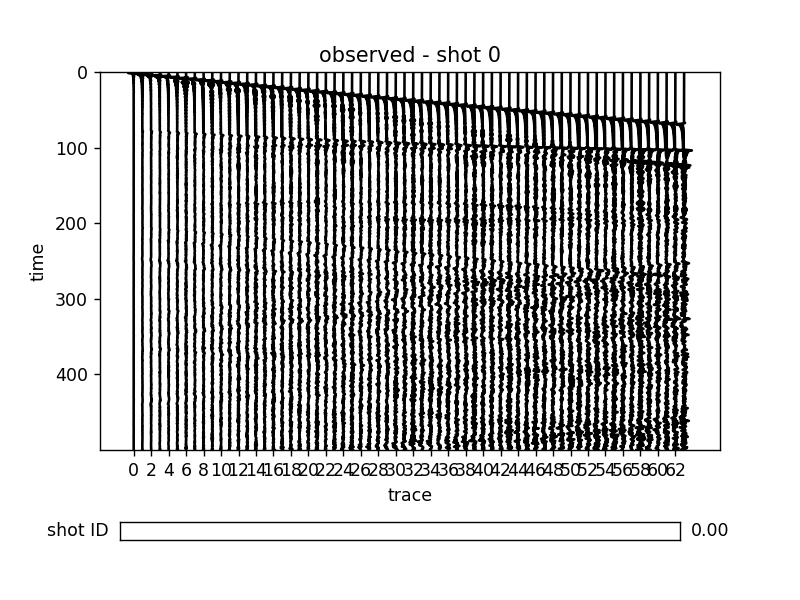

In [25]:
problem.acquisitions.plot_observed()

<IPython.core.display.Javascript object>


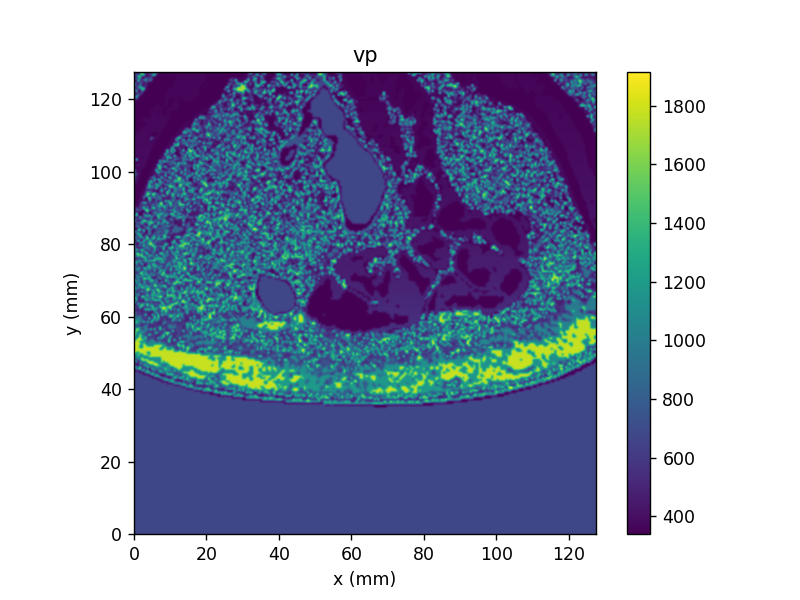

In [26]:
vp.plot()

In [27]:
#problem.data.plot()

In [28]:
# import matplotlib.pyplot as plt

# x2 = np.transpose(np.array(problem.acquisitions.sub_problem))
# plt.figure()
# plt.imshow(x2)
# plt.axis('off')
# plt.show()

In [29]:
# # NOT FOR MANUSCRIPT
# # GENERATES FIGURE 3
# fig = plt.figure(figsize=(15, 5))

# times = [10000]

# extent = [0, 0 + 1e-3 * problem.space.shape[0] * problem.space.spacing[0],
#            0 + 1e-3*problem.space.shape[1] * problem.space.spacing[1], 0]

# data_param = dict(vmin=-1e0, vmax=1e0, cmap='gray', aspect=1, extent=extent, interpolation='none')
# model_param = dict(vmin=1.5, vmax=2.5, cmap='gray', aspect=1, extent=extent, alpha=.3)

# ax0 = fig.add_subplot(111)
# _ = plt.imshow(np.transpose(u.data[times[0],40:-40,40:-40]), **data_param)
# _ = plt.imshow(np.transpose(vp), **model_param)
# ax0.set_ylabel('Depth (m)',  fontsize=20)
# ax0.text(0.5, 0.08, "t = {:.0f} ms".format(time[times[0]]), ha="center", color='k')